In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## [Task 1] Learning Basics of GAN

    -> sprint27-gan-pytorch.ipynb
    
    -> results

## [Task 2] Paper Survey

<br />

I am going to survey a paper of a kind of GANs named "Conditional Generative Adversarial Nets", and summarize it.

<br />

Conditional Generative Adversarial Nets

Mehdi Mirza, Simon Osindero

https://arxiv.org/abs/1411.1784?context=cs.CV

### Abstract

<br />

- This paper introduces the conditional version of generative adversarial nets, which can be constructed by simply feeding the data, $y$, to condition on to both the generator and discriminator.


- This model can generate MNIST digits conditioned on class labels.


- This paper illustrates how this model could be used to learn a multi-modal model, and provides preliminary examples of an application to image tagging to demonstrate how this approach can generate descriptive tags which are not part of training labels.

### Introduction

<br />

- In an unconditioned generative model, there is no control on modes of the data being generated. However, by conditioning the model on additional information it is possible to direct the data generation process. Such conditioning could be based on class labels, on some part of data for inpainting, or even on data from different modality.


- For empirical results this paper demonstrates two set of experiment. One on MNIST digit data set conditioned on class labels and one on MIR Flickr 25,000 dataset for multi-modal learning.

### Related Work

#### Multi-modal Learning For Image Labelling

<br />

- A first issue is to scale models like supervised neural networks to accommodate an extremely large number of predicted output categories. A second issue is that much of the work to date has focused on learning one-to-one mappings from input to output.


- One way to help address the first issue is to leverage additional information from other modalities.


- One way to address the second problem is to use a conditional probabilistic generative model.

### Conditional Adversarial Nets

<br />

- GAN can be extended to a conditional model if both the generator and discrim- inator are conditioned on some extra information $y$.


- $y$ could be any kind of auxiliary information, such as class labels or data from other modalities.


- This paper performs the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.


- In the generator the prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed. 


- In the discriminator $x$ and $y$ are presented as inputs and to a discriminative function (embodied again by a MLP in this case).

In [0]:
# Upload files

from google.colab import files
uploaded = files.upload()

Saving equation.png to equation.png


In [0]:
uploaded = files.upload()

Saving cgan.png to cgan.png


#### The Objective Function of A Two-Player Minimax Game

In [0]:
from IPython.display import Image,display_png

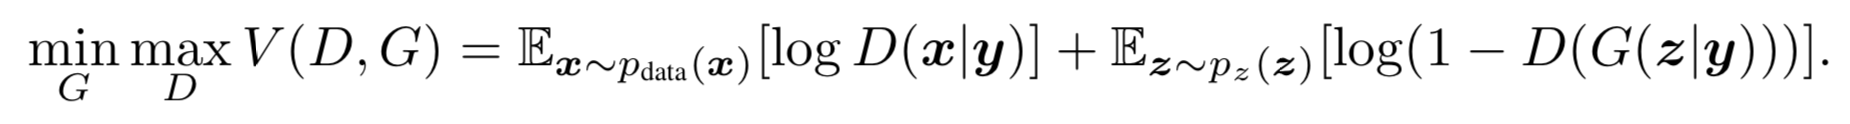

In [0]:
# Display images

display_png(Image('equation.png'))

#### The Structure of A Simple Conditional Adversarial Net

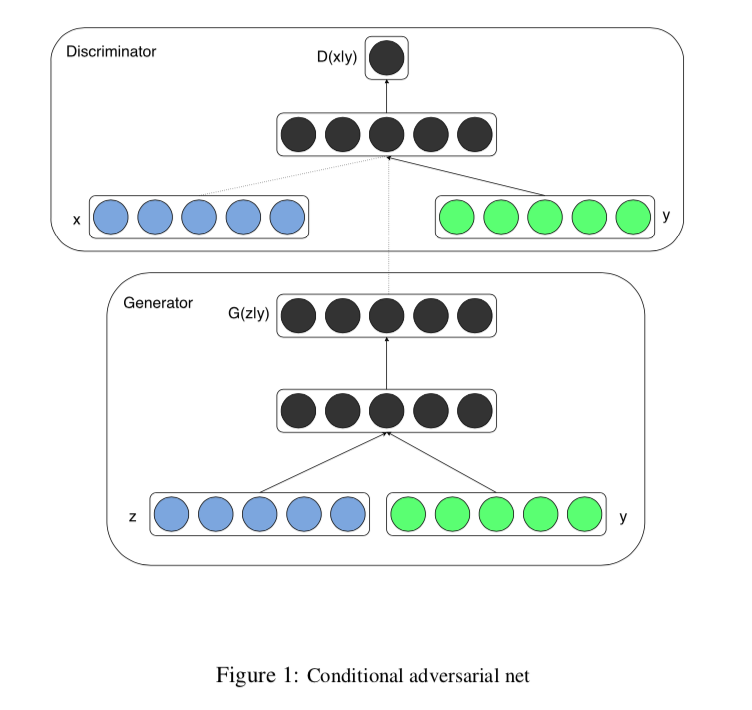

In [0]:
display_png(Image('cgan.png'))

## [Task 3] Paper Implementaion

<br />

I will implement and run the ConditionalGAN, and compare the results with results of original GAN.

### Original GAN

In [12]:
cd "gdrive/My Drive"

/content/gdrive/My Drive


In [0]:
# Create a directory for saving results of GAN

!mkdir gan-images

In [2]:
from __future__ import division, print_function

import sys

import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Dense, Dropout,
                          Flatten, Input, Reshape, ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("gan-images/%d.png" % epoch)
        plt.close()

In [0]:
gan = GAN()
gan.train(epochs=30000, batch_size=32, sample_interval=200)

### Conditional GAN

In [0]:
# Create a directory for saving results of Conditional GAN

!mkdir conditional-gan-images

In [0]:
from keras.layers import Embedding
from keras.layers import multiply

In [0]:
class CGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.n_classes = 10

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        validity = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], validity)
        self.combined.compile(loss='binary_crossentropy', 
                              optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.n_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')

        label_embedding = Flatten()(Embedding(self.n_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict([noise, labels])

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = self.discriminator.train_on_batch([gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            # Condition on labels
            sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)
        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        
        fig.savefig("conditional-gan-images/%d.png" % epoch)
        plt.close()

In [0]:
cgan = CGAN()
cgan.train(epochs=30000, batch_size=32, sample_interval=200)

### Compare the results of the Conditional GAN with the results of the original GAN

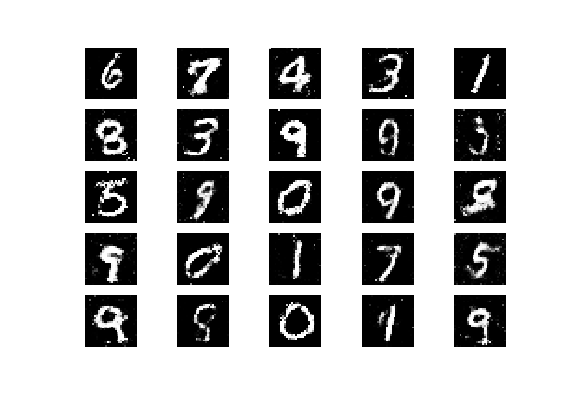

In [18]:
display_png(Image('gan-images/23600.png'))

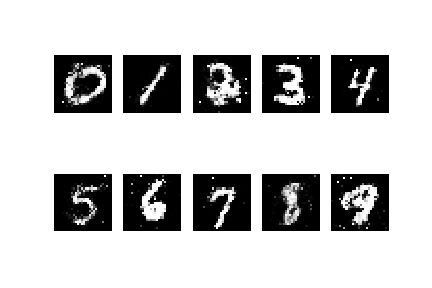

In [19]:
display_png(Image('conditional-gan-images/23600.png'))

    - Both of them are well-made!